<a href="https://colab.research.google.com/github/Kirti-Pant/ConvNeXT-Base-for-Brain-Tumor-Classification/blob/main/ConvNeXT_model_Training_and_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ConvNext Base

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import convnext_base


num_classes = 4


model = convnext_base(pretrained=True)


model.classifier[2] = nn.Linear(model.classifier[2].in_features, num_classes)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


dummy_input = torch.randn(1, 3, 224, 224).to(device)
outputs = model(dummy_input)
print(outputs)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


100%|██████████| 338M/338M [00:01<00:00, 197MB/s]


tensor([[-0.2895,  0.3799, -0.3236, -0.2638]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


Epoch [1/20], Train Loss: 0.2721, Train Acc: 0.9074, Val Loss: 0.0602, Val Acc: 0.9799
Epoch [2/20], Train Loss: 0.0444, Train Acc: 0.9840, Val Loss: 0.0362, Val Acc: 0.9851
Epoch [3/20], Train Loss: 0.0227, Train Acc: 0.9928, Val Loss: 0.0150, Val Acc: 0.9965
Epoch [4/20], Train Loss: 0.0067, Train Acc: 0.9980, Val Loss: 0.0125, Val Acc: 0.9974
Epoch [5/20], Train Loss: 0.0052, Train Acc: 0.9991, Val Loss: 0.0244, Val Acc: 0.9930
Epoch [6/20], Train Loss: 0.0244, Train Acc: 0.9934, Val Loss: 0.0835, Val Acc: 0.9712
Epoch [7/20], Train Loss: 0.0147, Train Acc: 0.9954, Val Loss: 0.0499, Val Acc: 0.9851
Epoch [8/20], Train Loss: 0.0150, Train Acc: 0.9963, Val Loss: 0.0469, Val Acc: 0.9878
Epoch [9/20], Train Loss: 0.0098, Train Acc: 0.9965, Val Loss: 0.0636, Val Acc: 0.9799
Epoch [10/20], Train Loss: 0.0291, Train Acc: 0.9912, Val Loss: 0.0315, Val Acc: 0.9904
Epoch [11/20], Train Loss: 0.0049, Train Acc: 0.9989, Val Loss: 0.0190, Val Acc: 0.9948
Epoch [12/20], Train Loss: 0.0009, Train 

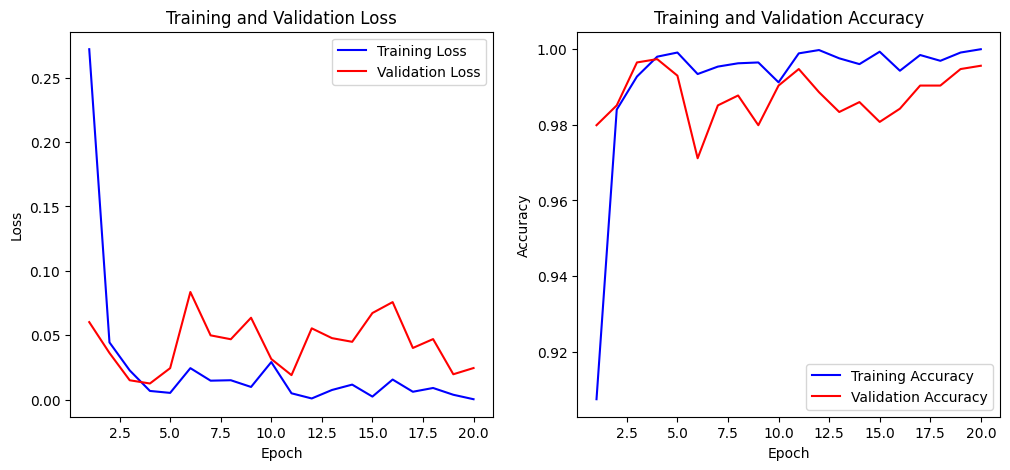

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


num_classes = 4
batch_size = 32
num_epochs = 20
learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(root='/content/dataset_split/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/dataset_split/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


convnext_base = models.convnext_base(pretrained=True)

convnext_base.classifier[2] = nn.Linear(convnext_base.classifier[2].in_features, num_classes)
convnext_base = convnext_base.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext_base.parameters(), lr=learning_rate)


train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(num_epochs):
    convnext_base.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = convnext_base(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total


    convnext_base.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = convnext_base(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total


    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


torch.save(convnext_base.state_dict(), 'convnext_base_trained.pth')


epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import os
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import pynvml

def get_gpu_power_watt(device_index=0):
    pynvml.nvmlInit()
    handle = pynvml.nvmlDeviceGetHandleByIndex(device_index)
    power_mw = pynvml.nvmlDeviceGetPowerUsage(handle)
    power_watt = power_mw / 1000.0
    pynvml.nvmlShutdown()
    return power_watt


folders = [
    "/content/dataset/pituitary",
    "/content/dataset/meningioma",
    "/content/dataset/notumor",
    "/content/dataset/glioma"
]

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

model = models.resnet152(pretrained=True).cuda()
model.eval()

valid_extensions = {".jpg", ".jpeg", ".png", ".bmp"}


total_energy_joules = 0.0
total_time_seconds = 0.0

for folder in folders:
    for file_name in os.listdir(folder):
        if os.path.splitext(file_name)[1].lower() in valid_extensions:
            image_path = os.path.join(folder, file_name)
            image = Image.open(image_path).convert("RGB")
            input_tensor = preprocess(image).unsqueeze(0).cuda()

            start_time = time.time()
            power_before = get_gpu_power_watt()

            with torch.no_grad():
                output = model(input_tensor)

            power_after = get_gpu_power_watt()
            end_time = time.time()

            avg_power = (power_before + power_after) / 2
            elapsed_time = end_time - start_time

            total_energy_joules += avg_power * elapsed_time
            total_time_seconds += elapsed_time


if total_time_seconds > 0:
    avg_power_watt = total_energy_joules / total_time_seconds
    print(f"Average GPU power consumption over all inferences: {avg_power_watt:.2f} Watts")
else:
    print("No images processed.")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Average GPU power consumption over all inferences: 59.13 Watts


## Figshare Test Dataset (D2)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classification Report:

                  precision    recall  f1-score   support

    glioma_tumor     1.0000    1.0000    1.0000       143
meningioma_tumor     1.0000    0.9934    0.9967       152
        no_tumor     1.0000    1.0000    1.0000       144
 pituitary_tumor     0.9935    1.0000    0.9967       152

        accuracy                         0.9983       591
       macro avg     0.9984    0.9984    0.9984       591
    weighted avg     0.9983    0.9983    0.9983       591



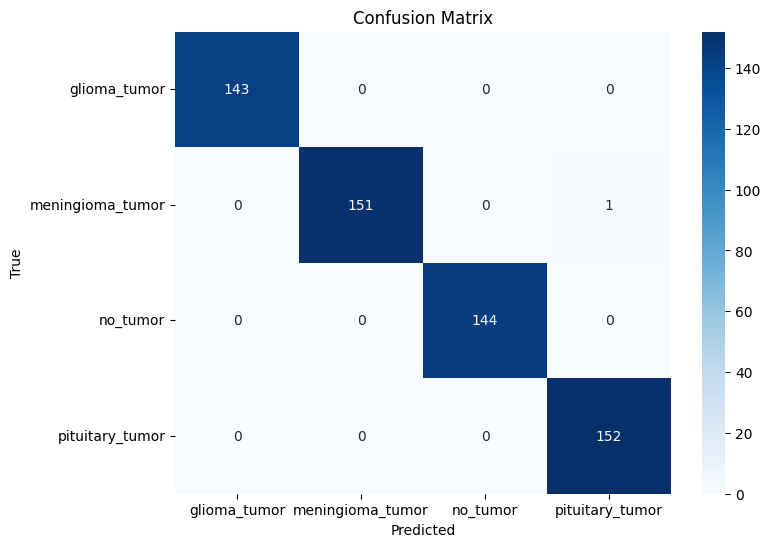

Macro-average AUC score: 1.0000
Cohen's Kappa Score: 0.9977


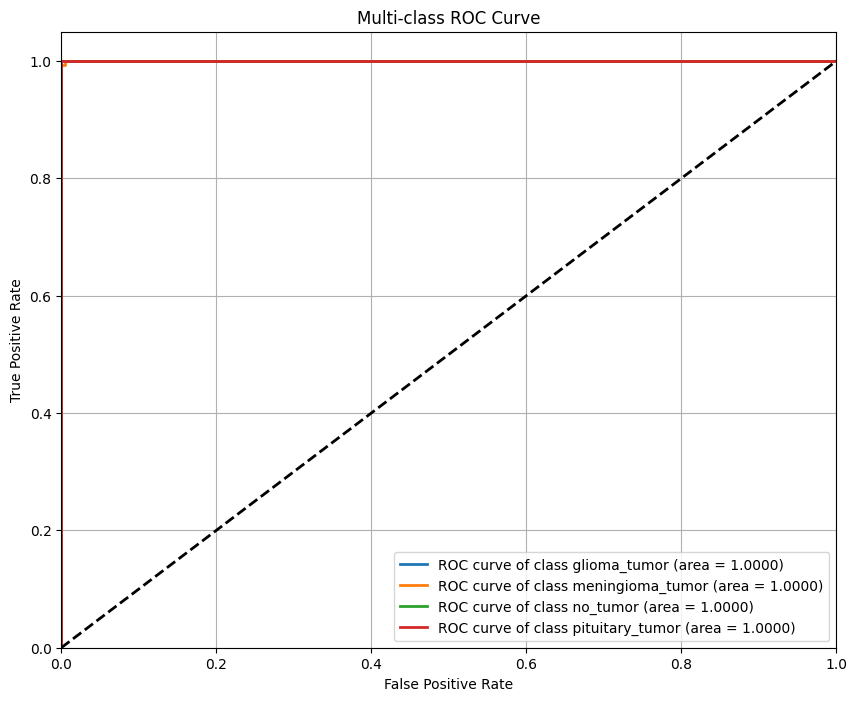

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']
num_classes = len(class_names)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/ntest', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = models.convnext_base(pretrained=False)
if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, num_classes)
else:
    raise ValueError('No recognizable classifier head found.')

model = model.to(device)


model.load_state_dict(torch.load('convnext_base_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_true_onehot = label_binarize(y_true, classes=range(num_classes))


auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")


kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")

from sklearn.metrics import roc_curve, auc


plt.figure(figsize=(10, 8))


for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve of class {class_names[i]} (area = {roc_auc:.4f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



## Kaggle Test Dataset (D3)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Classification Report:

              precision    recall  f1-score   support

   pituitary     0.9967    0.9967    0.9967       300
  meningioma     0.9935    0.9935    0.9935       306
     notumor     1.0000    0.9975    0.9988       405
      glioma     0.9967    1.0000    0.9983       300

    accuracy                         0.9969      1311
   macro avg     0.9967    0.9969    0.9968      1311
weighted avg     0.9970    0.9969    0.9969      1311



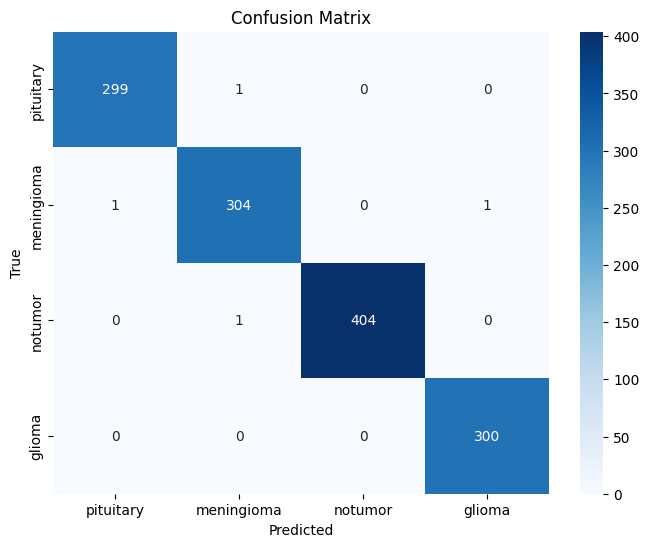

Macro-average AUC score: 0.9998
Cohen's Kappa Score: 0.9959


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['pituitary','meningioma', 'notumor',  'glioma']
num_classes = len(class_names)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/newtest/Testing', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = models.convnext_base(pretrained=False)
if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, num_classes)
else:
    raise ValueError('No recognizable classifier head found.')

model = model.to(device)


model.load_state_dict(torch.load('convnext_base_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_true_onehot = label_binarize(y_true, classes=range(num_classes))


auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")


kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")


## Other Dataset 254X254 (D4)

Classification Report:

              precision    recall  f1-score   support

      glioma     1.0000    0.9969    0.9985       324
  meningioma     0.9972    1.0000    0.9986       355
     notumor     0.9975    0.9975    0.9975       400
   pituitary     1.0000    1.0000    1.0000       351

    accuracy                         0.9986      1430
   macro avg     0.9987    0.9986    0.9986      1430
weighted avg     0.9986    0.9986    0.9986      1430



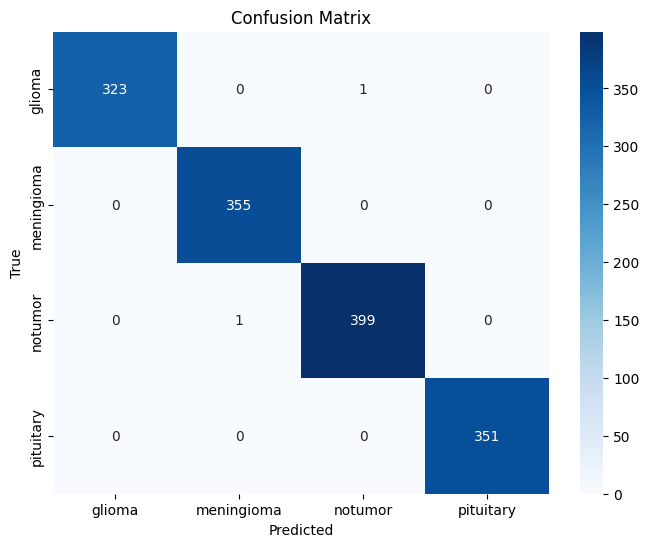

Macro-average AUC score: 1.0000
Cohen's Kappa Score: 0.9981


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, cohen_kappa_score
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
from sklearn.preprocessing import label_binarize
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


class_names = ['glioma','meningioma','notumor','pituitary']
num_classes = len(class_names)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/testcase/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


model = models.convnext_base(pretrained=False)
if hasattr(model, 'classifier') and isinstance(model.classifier, nn.Sequential):
    in_features = model.classifier[2].in_features
    model.classifier[2] = nn.Linear(in_features, num_classes)
else:
    raise ValueError('No recognizable classifier head found.')

model = model.to(device)


model.load_state_dict(torch.load('convnext_base_trained.pth', map_location=device))
model.eval()


y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)


print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


y_true_onehot = label_binarize(y_true, classes=range(num_classes))


auc = roc_auc_score(y_true_onehot, y_scores, average='macro', multi_class='ovr')
print(f"Macro-average AUC score: {auc:.4f}")


kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa Score: {kappa:.4f}")